In [1]:
using Revise
using QuantumOptics
using IonSim
import PyPlot
const plt = PyPlot

┌ Info: Precompiling IonSim [511e77fe-ab93-41f7-8f07-8f89809c6435]
└ @ Base loading.jl:1273


PyPlot

In [2]:
# set some plot configs
plt.matplotlib.rc("xtick", top=false)
plt.matplotlib.rc("ytick", right=false, left=false)
plt.matplotlib.rc("axes", labelsize=20, titlesize=20, grid=true)
plt.matplotlib.rc("axes", linewidth=2)
plt.matplotlib.rc("grid", alpha=0.25, linestyle="--")
plt.matplotlib.rc("font", family="Palatino", weight="medium")
plt.matplotlib.rc("figure", figsize=(8,4))
plt.matplotlib.rc("xtick.major", width=2)
plt.matplotlib.rc("ytick.major", width=2)

In this notebook we will demonstrate that the simulation correctly models laser-mediated interactions between different vibrational modes in a linear chain of ions.

We consider a system consisting of a two-level ion, an axial vibrational mode, a radial vibrational mode and a laser.

In [171]:
# Setup system
C = ca40(selected_level_structure=["S-1/2","D-1/2"])
L = laser()
νᵣ = √14 * 1e6  # radial trap frequency
νₐ = 1.5e6  # axial trap frequency
chain = linearchain(ions=[C], com_frequencies=(x=νᵣ, y=νᵣ, z=νₐ), selected_modes=(x=[1], y=[], z=[1]))
T = trap(configuration=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[L])
L.k = (x̂ + ẑ)/√2
L.ϵ = ẑ
Efield_from_rabi_frequency!(5e5, T, 1, 1, ("S-1/2","D-1/2"));  # set carrier transition Rabi frequency to 500 kHz

┌ Warning: !(ϵ ⟂ k)
└ @ IonSim /Users/joe/Desktop/IonSim/IonSim.jl/src/lasers.jl:81
┌ Warning: !(ϵ ⟂ k)
└ @ IonSim /Users/joe/Desktop/IonSim/IonSim.jl/src/lasers.jl:76


In [172]:
axial = T.configuration.vibrational_modes.z[1]
radial = T.configuration.vibrational_modes.x[1]
axial.N = 8; radial.N = 8  # set mode dimensions

ρᵢ_ion = dm(C["S-1/2"])
ρᵢ_axial = thermalstate(axial, 0.5)
ρᵢ_radial = thermalstate(radial, 0.5)
ρᵢ = ρᵢ_ion ⊗ ρᵢ_radial ⊗ ρᵢ_axial;  # Set initial state to |↓, n̄ᵣ=0.5, n̄ₐ=0.5⟩

First we will look at a scan of the ion's excited state population as a function of the laser's detuning:

In [173]:
tspan = 0:0.25:400
fout(t, ρ) = expect(ion_projector(T, "D-1/2"), ρ)
J = (-dm(C["S-1/2"]) + dm(C["D-1/2"])) ⊗ one(radial.basis) ⊗ one(axial.basis)  # Collapse operator
γ = 1e4 * 1e-6  # Strength of collapse operator (adjusted to simulation timescale)
ωc = transition_frequency(T, 1, ("S-1/2", "D-1/2"))  # Carrier transition frequency

Scan laser detuning
Δlist = range(ωc, stop=ωc + 2νᵣ + 1e5, length=300)
exclist = []
for Δ in Δlist
    L.Δ = Δ
    h = hamiltonian(T, rwa_cutoff=2.5e6, lamb_dicke_order=2)
    _, sol = timeevolution.master_dynamic(tspan, ρᵢ, (t, ρ) -> (h(t, ρ), [J], [J], [γ]), fout=fout)
    push!(exclist, real(sol[end]))
end 

2.239399193848153e6

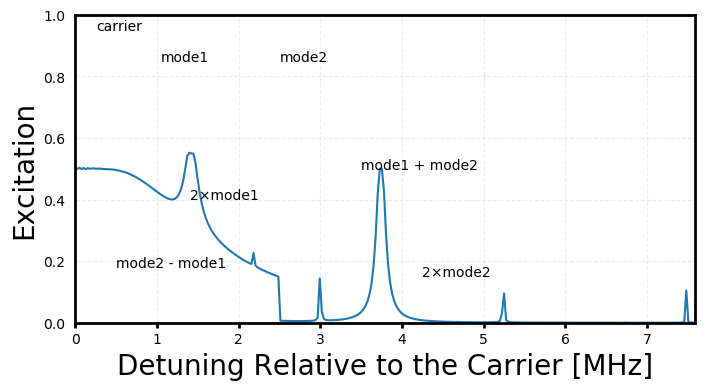

In [164]:
plt.plot(@.((Δlist - ωc) / 1e6) , exclist)
plt.text(0.25, 0.95, "carrier")
plt.text(1 + 0.05, 0.85, "mode1")
plt.text(√6 + 0.05, 0.85, "mode2")
plt.text(0.5, 0.18, "mode2 - mode1")
plt.text(1.4, 0.4, "2×mode1")
plt.text(√6 + 1 + 0.05, 0.5, "mode1 + mode2")
plt.text(4.25, 0.15, "2×mode2")
plt.xlim(0, (Δlist[end] - ωc) / 1e6 + 0.01)
plt.ylim(0, 1)
plt.xlabel("Detuning Relative to the Carrier [MHz]")
plt.ylabel("Excitation")
plt.show()

Next, we will drive the first-order axial blue sideband of the carrier transition and compare the results for an initial vibrational state of |↓, n̄ᵣ=0, n̄ₐ=1.5⟩ versus |↓, n̄ᵣ=1.5, n̄ₐ=0⟩.

In [176]:
Efield_from_rabi_frequency!(1e6, T, 1, 1, ("S-1/2","D-1/2"));  # set carrier transition Rabi frequency to 1 MHz
tspan = 0:0.25:800
L.Δ = ωc + axial.ν
h = hamiltonian(T, rwa_cutoff=1e4)

ρᵢ_axial = thermalstate(axial, 1.5)
ρᵢ_radial = thermalstate(radial, 0)
ρᵢ = ρᵢ_ion ⊗ ρᵢ_radial ⊗ ρᵢ_axial  # Set initial state to |↓, n̄ᵣ=0, n̄ₐ=1.5⟩
tout, sol_ax = timeevolution.schroedinger_dynamic(tspan, ρᵢ, h, fout=fout)

ρᵢ_axial = thermalstate(axial, 0)
ρᵢ_radial = thermalstate(radial, 1.5)
ρᵢ = ρᵢ_ion ⊗ ρᵢ_radial ⊗ ρᵢ_axial  # Set initial state to |↓, n̄ᵣ=1.5, n̄ₐ=0⟩
tout, sol_rad = timeevolution.schroedinger_dynamic(tspan, ρᵢ, h, fout=fout);

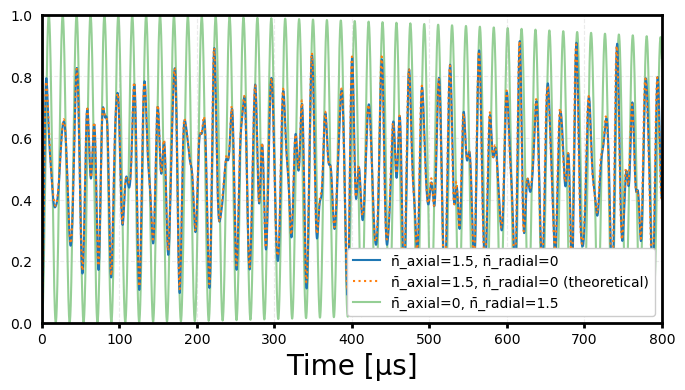

In [179]:
plt.plot(tout, sol_ax, label="n̄_axial=1.5, n̄_radial=0")
plt.plot(tout, analytical.rabi_flop.(tout, 1, get_η(axial, L, C), 1.5, s=1), ls="dotted", label="n̄_axial=1.5, n̄_radial=0 (theoretical)")
plt.plot(tout, sol_rad, alpha=0.5, label="n̄_axial=0, n̄_radial=1.5", zorder=-1)
plt.legend(loc=4, framealpha=1)
plt.ylim(0, 1)
plt.xlim(0, tout[end])
plt.xlabel("Time [μs]")
plt.show()

We see (blue curve) that, when the axial mode begins in a thermal state with mean occupation of 1.5 quanta, the oscillations exhibit a large spectral content -- since the coupling strength of the sideband transition depends strongly on the occupation of the mode. The dotted orange curve is the theoretical prediction.

On the other hand, when the axial mode begins in its ground state but the radial mode begins in a thermal state with mean occupation 1.5 quanta, we see (green curve) that the dominant effect is a slow decay. To first order, this is described by an n-dependent dispersive shift of the axial sideband transition due to off-resonant interaction with the radial mode.

If we instead drive the radial sideband, we produce analogous results: 

In [180]:
tspan = 0:0.25:800
L.Δ = ωc + radial.ν
h = hamiltonian(T, rwa_cutoff=1e4)

ρᵢ_axial = thermalstate(axial, 1.5)
ρᵢ_radial = thermalstate(radial, 0)
ρᵢ = ρᵢ_ion ⊗ ρᵢ_radial ⊗ ρᵢ_axial  # Set initial state to |↓, n̄ᵣ=0, n̄ₐ=1.5⟩
tout, sol_ax = timeevolution.schroedinger_dynamic(tspan, ρᵢ, h, fout=fout)

ρᵢ_axial = thermalstate(axial, 0)
ρᵢ_radial = thermalstate(radial, 1.5)
ρᵢ = ρᵢ_ion ⊗ ρᵢ_radial ⊗ ρᵢ_axial  # Set initial state to |↓, n̄ᵣ=1.5, n̄ₐ=0⟩
tout, sol_rad = timeevolution.schroedinger_dynamic(tspan, ρᵢ, h, fout=fout);

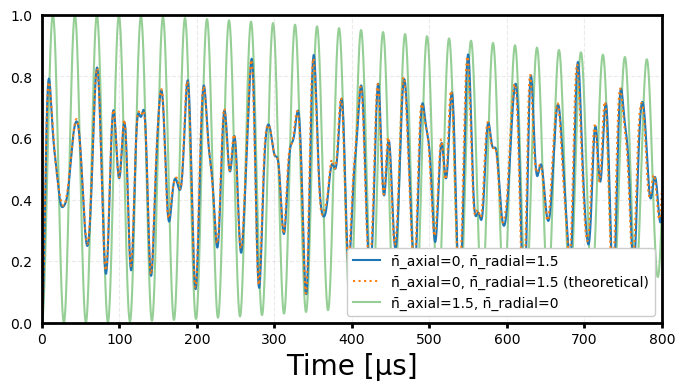

In [181]:
plt.plot(tout, sol_rad, label="n̄_axial=0, n̄_radial=1.5")
plt.plot(tout, analytical.rabi_flop.(tout, 1, get_η(radial, L, C), 1.5, s=1), ls="dotted", label="n̄_axial=0, n̄_radial=1.5 (theoretical)")
plt.plot(tout, sol_ax, alpha=0.5, label="n̄_axial=1.5, n̄_radial=0", zorder=-1)
plt.legend(loc=4, framealpha=1)
plt.ylim(0, 1)
plt.xlim(0, tout[end])
plt.xlabel("Time [μs]")
plt.show()

The main difference between this and the previous plot (aside from the role reversal of the vibrational modes) is that the coupling strengths are all scaled down since the Lamb Dicke factor for the radial mode is smaller (η ∝ 1/√ν).

Finally, we set the laser detuning equal to the carrier transition plus the sum of the two trap frequencies. In this case, we drive a second-order sideband transition that involves simultaneously increasing the occupation numbers of both modes by one quanta.

In [182]:
tspan = 0:10:4000
L.Δ = ωc + radial.ν + axial.ν
h = hamiltonian(T, rwa_cutoff=1e4)

ρᵢ_axial = thermalstate(axial, 1.5)
ρᵢ_radial = thermalstate(radial, 0)
ρᵢ = ρᵢ_ion ⊗ ρᵢ_radial ⊗ ρᵢ_axial  # Set initial state to |↓, n̄ᵣ=0, n̄ₐ=1.5⟩
tout, sol_ax = timeevolution.schroedinger_dynamic(tspan, ρᵢ, h, fout=fout)

ρᵢ_axial = thermalstate(axial, 0)
ρᵢ_radial = thermalstate(radial, 1.5)
ρᵢ = ρᵢ_ion ⊗ ρᵢ_radial ⊗ ρᵢ_axial  # Set initial state to |↓, n̄ᵣ=1.5, n̄ₐ=0⟩
tout, sol_rad = timeevolution.schroedinger_dynamic(tspan, ρᵢ, h, fout=fout)

ρᵢ_axial = thermalstate(axial, 1.5)
ρᵢ_radial = thermalstate(radial, 1.5)
ρᵢ = ρᵢ_ion ⊗ ρᵢ_radial ⊗ ρᵢ_axial  # Set initial state to |↓, n̄ᵣ=1.5, n̄ₐ=1.5⟩
tout, sol_ax_rad = timeevolution.schroedinger_dynamic(tspan, ρᵢ, h, fout=fout);

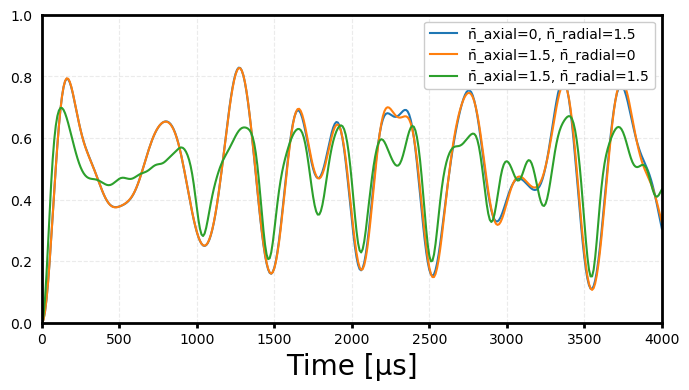

In [183]:
plt.plot(tout, sol_rad, label="n̄_axial=0, n̄_radial=1.5")
plt.plot(tout, sol_ax, label="n̄_axial=1.5, n̄_radial=0")
plt.plot(tout, sol_ax_rad, label="n̄_axial=1.5, n̄_radial=1.5")
plt.legend(loc=1, framealpha=1)
plt.ylim(0, 1)
plt.xlim(0, tout[end])
plt.xlabel("Time [μs]")
plt.show()

We see that in this case the results for ρᵢ = |↓, n̄ᵣ=0, n̄ₐ=1.5⟩ and  ρᵢ = |↓, n̄ᵣ=1.5, n̄ₐ=0⟩ are very similar. 

As a final note we mention that, when more than one vibrational mode is present in the simulation, we can indepently set the order of the Lamb-Dicke approximation for each mode by inputing a vector `V` to the keyword argument `lamb_dicke_order` in the `hamiltonian` function. In this case, `typeof(V) ≡ Vector{<:Int}` and the length of `V` must be equal to the number of modes.

In [194]:
tspan = 0:5:1000
ρᵢ_axial = thermalstate(axial, 0)
ρᵢ_radial = thermalstate(radial, 0)
ρᵢ = ρᵢ_ion ⊗ ρᵢ_radial ⊗ ρᵢ_axial  # Set initial state to |↓, n̄ᵣ=0, n̄ₐ=0⟩

L.Δ = ωc + 2radial.ν  # Set detuning to second order radial sideband
h = hamiltonian(T, rwa_cutoff=1e4, lamb_dicke_order=[1, 2])  # First order LD approx on radial mode and second order on axial mode
tout, sol_rad = timeevolution.schroedinger_dynamic(tspan, ρᵢ, h, fout=fout)

L.Δ = ωc + 2axial.ν  # Set detuning to second order axial sideband
h = hamiltonian(T, rwa_cutoff=1e4, lamb_dicke_order=[1, 2])
tout, sol_ax = timeevolution.schroedinger_dynamic(tspan, ρᵢ, h, fout=fout)

L.Δ = ωc + radial.ν + axial.ν  # Set detuning to axial + radial sideband
h = hamiltonian(T, rwa_cutoff=1e4, lamb_dicke_order=[1, 2])
tout, sol_rad_ax = timeevolution.schroedinger_dynamic(tspan, ρᵢ, h, fout=fout)

L.Δ = ωc + 2radial.ν  # Set detuning to second order radial sideband
h = hamiltonian(T, rwa_cutoff=1e4, lamb_dicke_order=[2, 1])  # First order LD approx on radial mode and second order on axial mode
tout, sol_radr = timeevolution.schroedinger_dynamic(tspan, ρᵢ, h, fout=fout)

L.Δ = ωc + 2axial.ν  # Set detuning to second order axial sideband
h = hamiltonian(T, rwa_cutoff=1e4, lamb_dicke_order=[2, 1])
tout, sol_axr = timeevolution.schroedinger_dynamic(tspan, ρᵢ, h, fout=fout)

L.Δ = ωc + radial.ν + axial.ν  # Set detuning to axial + radial sideband
h = hamiltonian(T, rwa_cutoff=1e4, lamb_dicke_order=[2, 1])
tout, sol_rad_axr = timeevolution.schroedinger_dynamic(tspan, ρᵢ, h, fout=fout);

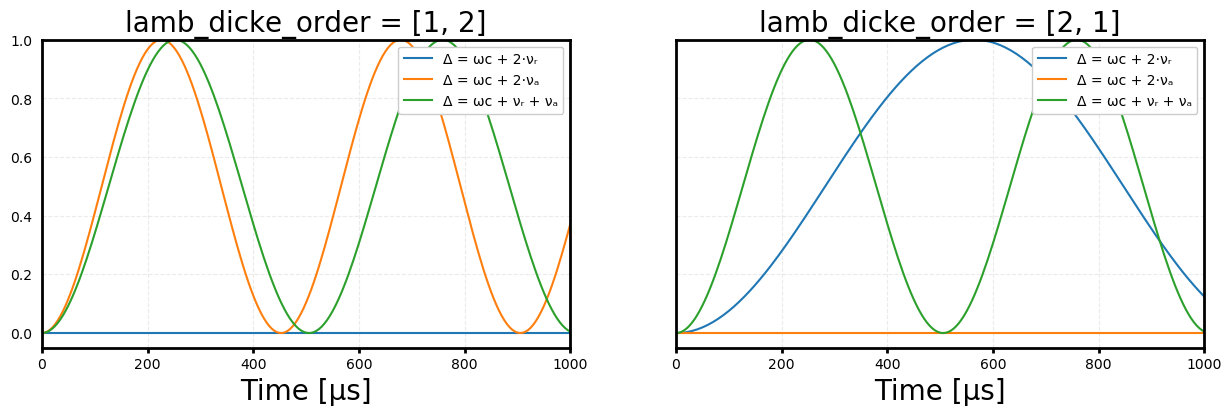

In [199]:
fig, ax = plt.subplots(1, 2, sharey=true, figsize=(15, 4))
ax[1].plot(tout, sol_rad, label="Δ = ωc + 2⋅νᵣ")
ax[1].plot(tout, sol_ax, label="Δ = ωc + 2⋅νₐ")
ax[1].plot(tout, sol_rad_ax, label="Δ = ωc + νᵣ + νₐ")
ax[1].legend(loc=1, framealpha=1)
ax[1].set_title("lamb_dicke_order = [1, 2]")
ax[2].plot(tout, sol_radr, label="Δ = ωc + 2⋅νᵣ")
ax[2].plot(tout, sol_axr, label="Δ = ωc + 2⋅νₐ")
ax[2].plot(tout, sol_rad_axr, label="Δ = ωc + νᵣ + νₐ")
ax[2].set_title("lamb_dicke_order = [2, 1]")
ax[2].legend(loc=1, framealpha=1)
plt.ylim(-0.05, 1)
ax[1].set_xlim(0, tout[end]); ax[2].set_xlim(0, tout[end])
ax[1].set_xlabel("Time [μs]"); ax[2].set_xlabel("Time [μs]")
plt.show()